In [160]:
from __future__ import annotations

import hashlib
from pathlib import Path
import os, json
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from transformers import AutoModelForSequenceClassification, Trainer
from datasets import Dataset
import torch


from datasets import Dataset
from transformers import AutoTokenizer
import evaluate

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

# Größen in cm → umrechnen in inches
cm = 1/2.54



# marker und dicken von linien und der achsen und alles sollte einheitlich sein
plt.rcParams.update({
    "figure.figsize": (18*cm, 8*cm),   # default: 18×8 cm
    "font.size": 10,                    # Standardschriftgröße
    "axes.titlesize": 10,
    "axes.labelsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.dpi": 300, # für saubere Notebooks/Export
    "lines.linewidth": 1.0,
    "lines.markersize": 4,
    "axes.linewidth": 1.0,
    "xtick.major.width": 1.0,
    "ytick.major.width": 1.0,
    "xtick.minor.width": 1.0,
    "ytick.minor.width": 1.0,
})

In [161]:
EXPERIMENTS_DIR = Path("experiments")
metrics = pd.read_csv(EXPERIMENTS_DIR / "metrics_long.csv")


global_metrics = pd.read_csv(EXPERIMENTS_DIR / "runs_global.csv")
config_df = global_metrics["config_json"].apply(json.loads).apply(pd.Series)
global_metrics = pd.concat([global_metrics.drop(columns=["config_json"]), config_df], axis=1)
global_metrics.head()

,experiment_id,accuracy,macro_f1,weighted_f1,batch_size,bf16,class_weight_eps,class_weight_method,epochs,eval_strategy,...,report_to,run_name,save_strategy,save_total_limit,seed,text_col,truncation,use_class_weights,warmup_ratio,weight_decay
0,mmBERT-base_20260122_013213,0.895575,0.884640,NaN,32,True,0.000001,inv_freq,4,epoch,...,none,mmBERT_lr5e-05_bs32_len256,epoch,2,42,text_stripped,True,True,0.06,0.01
1,mmBERT-base_20260122_012030,0.893719,0.883113,NaN,32,True,0.000001,inv_freq,4,epoch,...,none,mmBERT_lr5e-05_bs32_len128,epoch,2,42,text_stripped,True,True,0.06,0.01
2,mmBERT-base_20260122_004952,0.895695,0.885037,NaN,16,True,0.000001,inv_freq,4,epoch,...,none,mmBERT_lr5e-05_bs16_len384,epoch,2,42,text_stripped,True,True,0.06,0.01
3,mmBERT-base_20260122_002353,0.896473,0.887637,NaN,16,True,0.000001,inv_freq,4,epoch,...,none,mmBERT_lr5e-05_bs16_len256,epoch,2,42,text_stripped,True,True,0.06,0.01
4,mmBERT-base_20260122_000205,0.893240,0.882495,NaN,16,True,0.000001,inv_freq,4,epoch,...,none,mmBERT_lr5e-05_bs16_len128,epoch,2,42,text_stripped,True,True,0.06,0.01


In [162]:
global_metrics.head()
print(global_metrics.columns)

Index(['experiment_id', 'accuracy', 'macro_f1', 'weighted_f1', 'batch_size',
       'bf16', 'class_weight_eps', 'class_weight_method', 'epochs',
       'eval_strategy', 'experiment_id', 'fp16', 'gradient_accumulation_steps',
       'greater_is_better', 'label_col', 'label_smoothing_factor',
       'load_best_model_at_end', 'logging_steps', 'lr', 'lr_scheduler_type',
       'max_length', 'metric_for_best_model', 'model_ckpt', 'padding',
       'report_to', 'run_name', 'save_strategy', 'save_total_limit', 'seed',
       'text_col', 'truncation', 'use_class_weights', 'warmup_ratio',
       'weight_decay'],
      dtype='object')


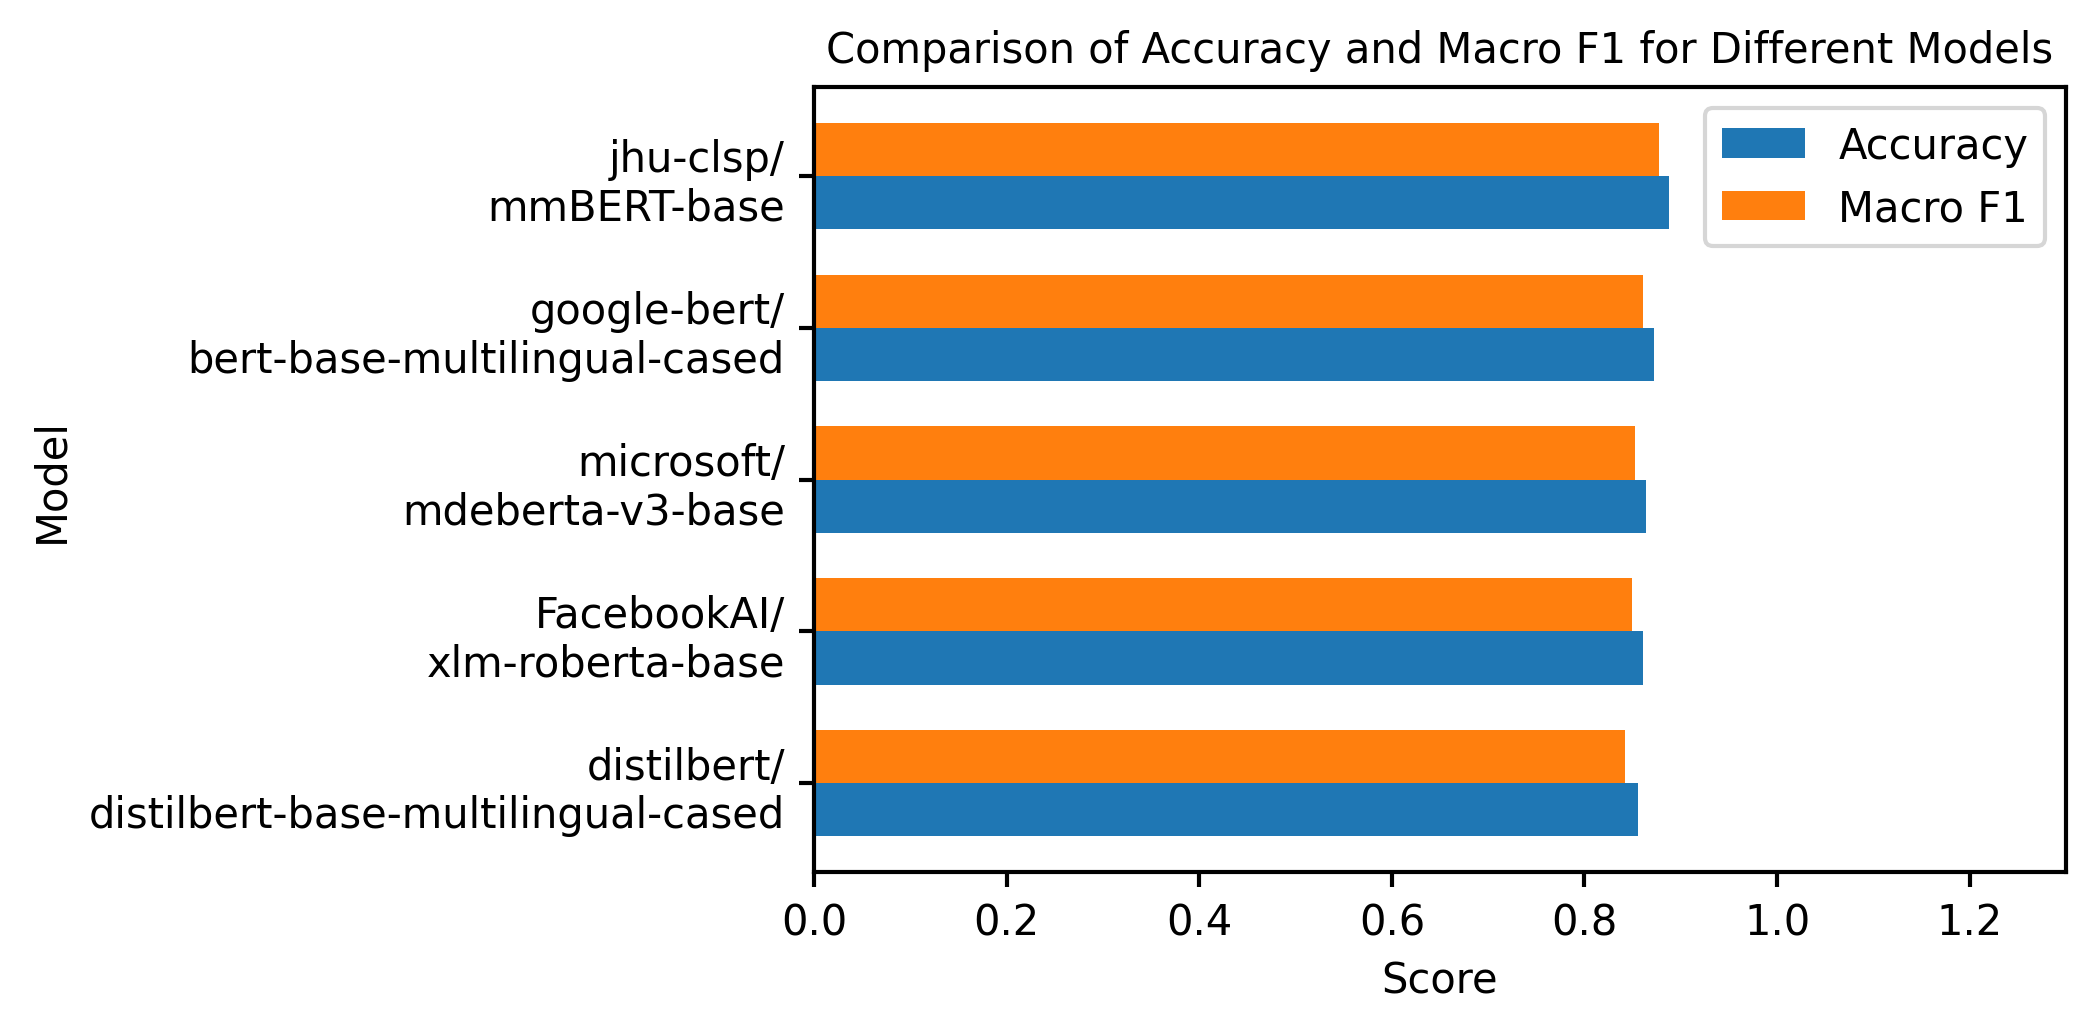

In [163]:
# only want to compare different models with the same batch size and learning rate
comparison_metrics = global_metrics[
    (global_metrics["batch_size"] == 32) & (global_metrics["lr"] == 2e-5) & (global_metrics["max_length"] == 256)
]
comparison_metrics.head(10)
# check for exact duplicates (excluding experiment_id, accuracy, macro_f1,weighted_f1)
duplicate_rows = comparison_metrics.duplicated(subset=["model_ckpt", "batch_size", "lr", "max_length"], keep=False)
comparison_metrics[duplicate_rows]

# drop the one with lower macro_f1
comparison_metrics = comparison_metrics.drop_duplicates(
    subset=["model_ckpt", "batch_size", "lr", "max_length"], keep="first"
)
comparison_metrics



# plot a bar chart comparing accuracy and macro_f1 for different models
# sort by macro f1
comparison_metrics = comparison_metrics.sort_values(by="macro_f1", ascending=True)
fig, ax = plt.subplots(figsize=(18*cm, 9*cm))
bar_width = 0.35
index = np.arange(len(comparison_metrics))

# Create horizontal bars
ax.barh(index, comparison_metrics["accuracy"], bar_width, label="Accuracy")
ax.barh(index + bar_width, comparison_metrics["macro_f1"], bar_width, label="Macro F1")

ax.set_ylabel("Model")
ax.set_xlabel("Score")
ax.set_title("Comparison of Accuracy and Macro F1 for Different Models")

# Split the label names at "/" and break the lines
labels = [re.sub(r'/', '/\n', name) for name in comparison_metrics["model_ckpt"]]
ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(labels)
ax.set_xlim(0,1.3)
ax.legend()
plt.tight_layout()
plt.show()

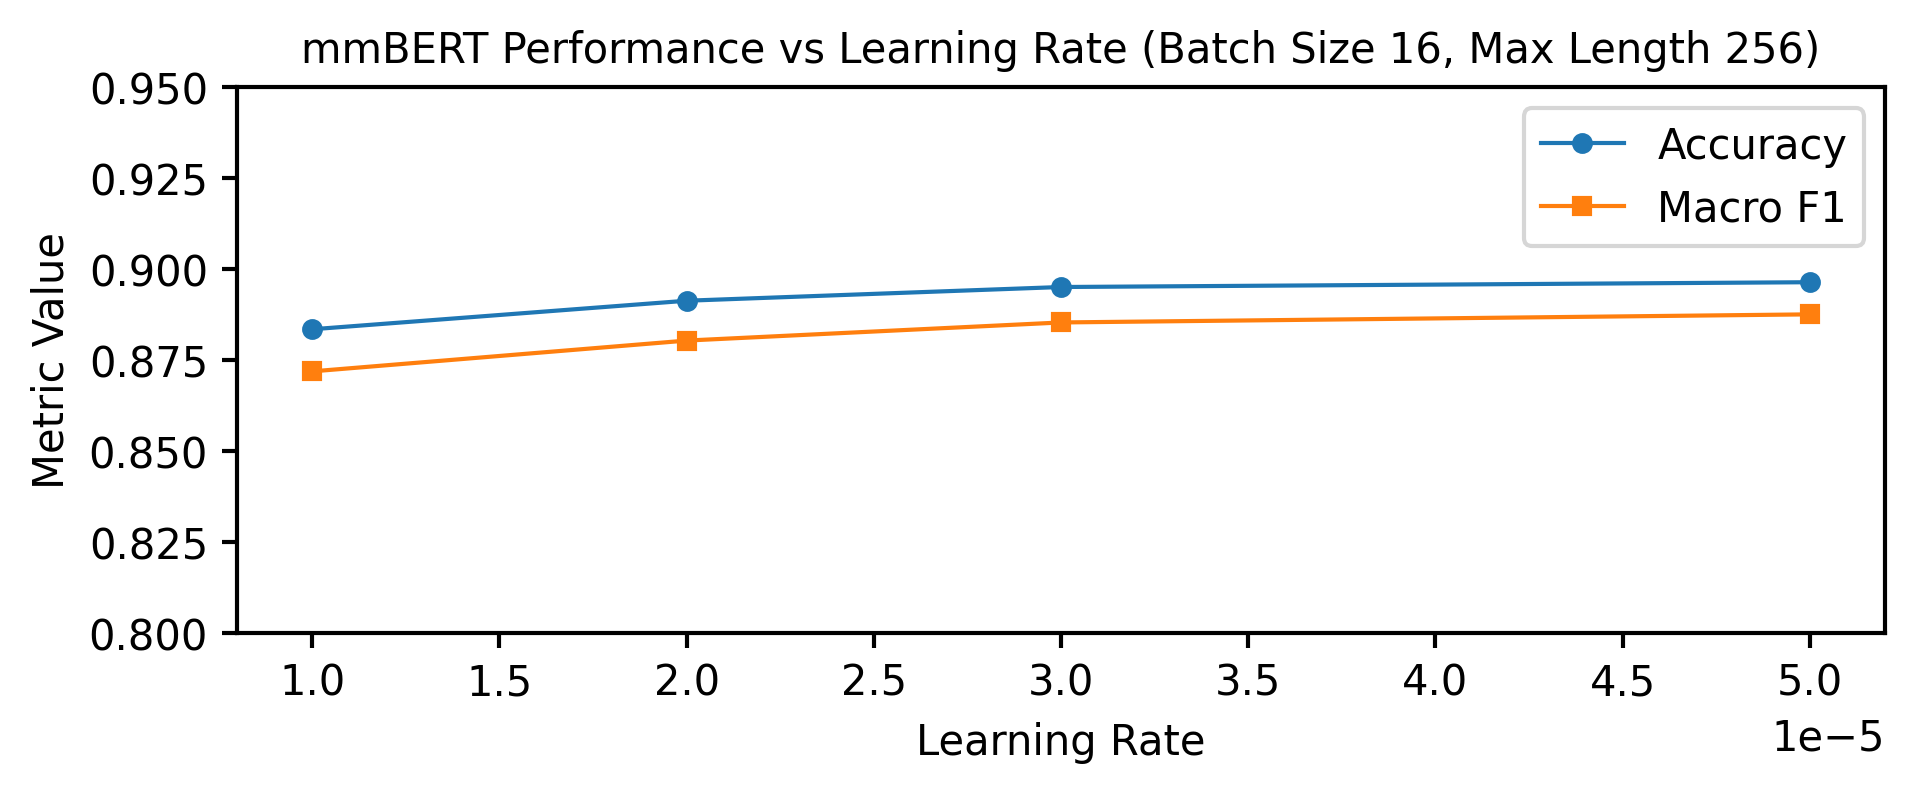

In [164]:
# compare only mmBERT to each other (as function of learning rate for batch size 32 and max_length 256)
mmBERT_metrics = global_metrics[
    (global_metrics["model_ckpt"].str.contains("mmBERT")) &
    (global_metrics["batch_size"] == 16) & (global_metrics["max_length"] == 256)
]
mmBERT_metrics = mmBERT_metrics.sort_values(by="lr")

# drop duplicates if any
mmBERT_metrics = mmBERT_metrics.drop_duplicates(
    subset=["model_ckpt", "batch_size", "lr", "max_length"], keep="first"
)


fig, ax = plt.subplots(figsize=(18*cm, 6*cm))


# scatter plot of learning rate vs accuracy and macro_f1
ax.plot(mmBERT_metrics["lr"], mmBERT_metrics["accuracy"], marker='o', label="Accuracy")
ax.plot(mmBERT_metrics["lr"], mmBERT_metrics["macro_f1"], marker='s', label="Macro F1")
ax.set_ylim(0.8,0.95)
ax.set_xlabel("Learning Rate")
ax.set_ylabel("Metric Value")
ax.set_title("mmBERT Performance vs Learning Rate (Batch Size 16, Max Length 256)")
ax.legend()
plt.show()



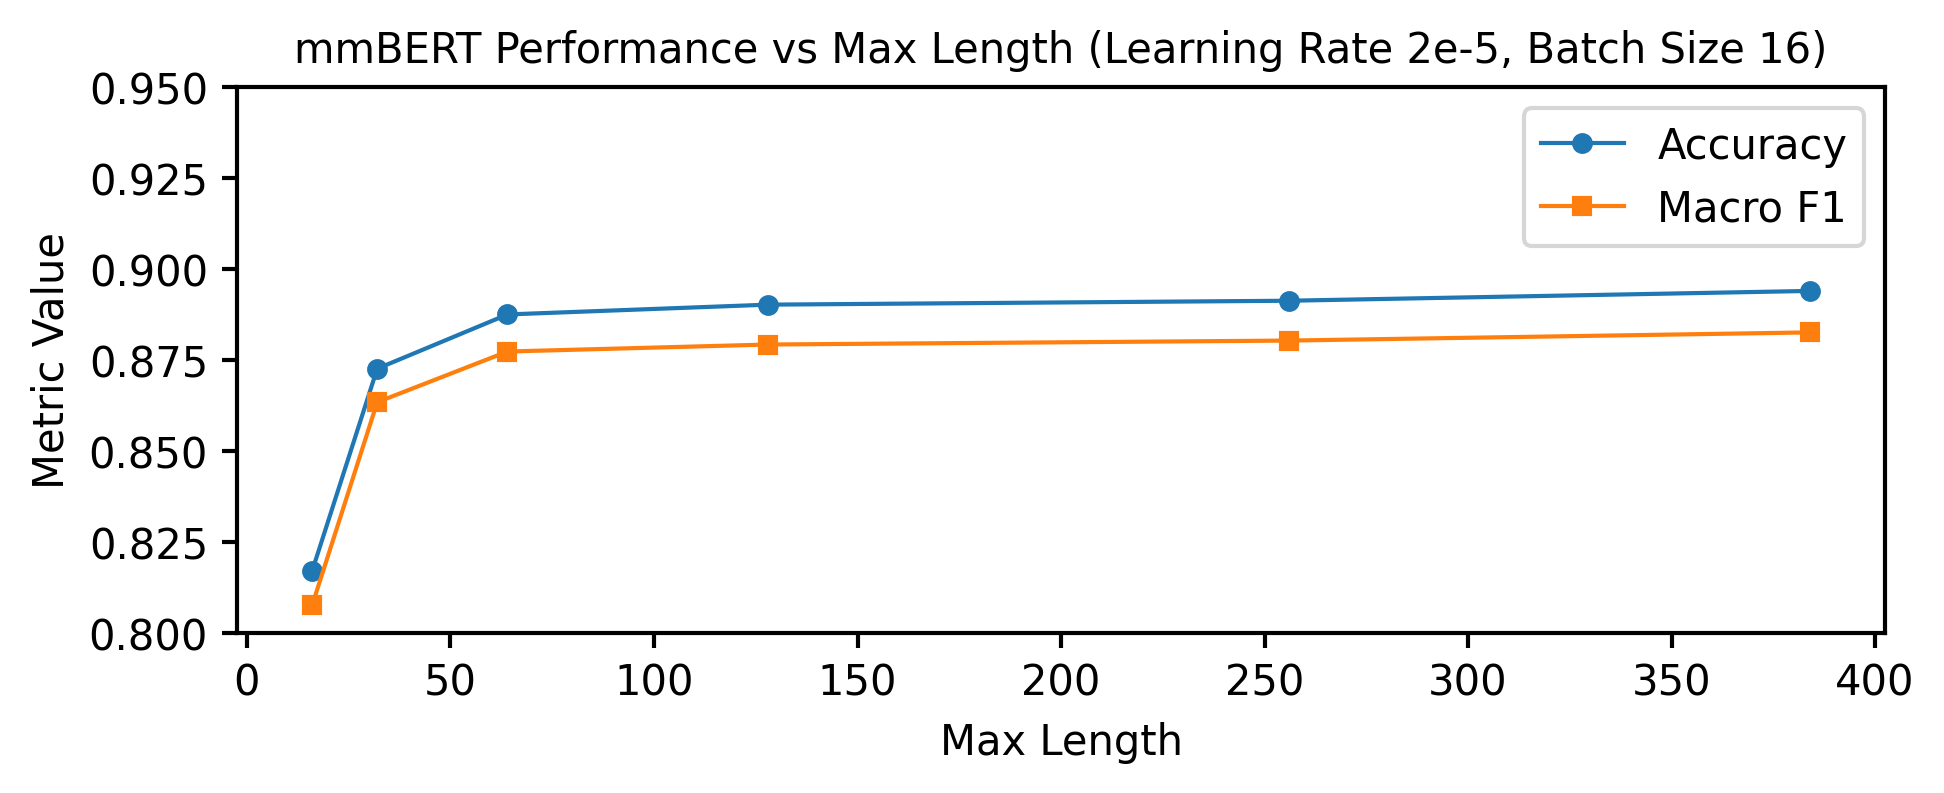

In [165]:
# compare only mmBERT to each other (as function of max_length for batch size 16 and learning rate 2e-5)
mmBERT_metrics_bs = global_metrics[
    (global_metrics["model_ckpt"].str.contains("mmBERT")) &
    (global_metrics["lr"] == 2e-5) & (global_metrics["batch_size"] == 16)
]
mmBERT_metrics_bs = mmBERT_metrics_bs.sort_values(by="max_length")

# drop duplicates if any
mmBERT_metrics_bs = mmBERT_metrics_bs.drop_duplicates(
    subset=["model_ckpt", "batch_size", "lr", "max_length"], keep="first"
)

fig, ax = plt.subplots(figsize=(18*cm, 6*cm))

# scatter plot of max_length vs accuracy and macro_f1
ax.plot(mmBERT_metrics_bs["max_length"], mmBERT_metrics_bs["accuracy"], marker='o', label="Accuracy")
ax.plot(mmBERT_metrics_bs["max_length"], mmBERT_metrics_bs["macro_f1"], marker='s', label="Macro F1")
ax.set_ylim(0.8,0.95)
ax.set_xlabel("Max Length")
ax.set_ylabel("Metric Value")
ax.set_title("mmBERT Performance vs Max Length (Learning Rate 2e-5, Batch Size 16)")
ax.legend()
plt.show()

In [166]:
# select the best mmBERT model based on macro_f1
best_mmBERT = mmBERT_metrics_bs.loc[mmBERT_metrics_bs["macro_f1"].idxmax()]
best_mmBERT

experiment_id                  mmBERT-base_20260121_202810
accuracy                                          0.894078
macro_f1                                          0.882679
weighted_f1                                            NaN
batch_size                                              16
bf16                                                  True
class_weight_eps                                  0.000001
class_weight_method                               inv_freq
epochs                                                   4
eval_strategy                                        epoch
experiment_id                              20260121_202810
fp16                                                 False
gradient_accumulation_steps                              2
greater_is_better                                     True
label_col                                      prdtypecode
label_smoothing_factor                                 0.0
load_best_model_at_end                                Tr

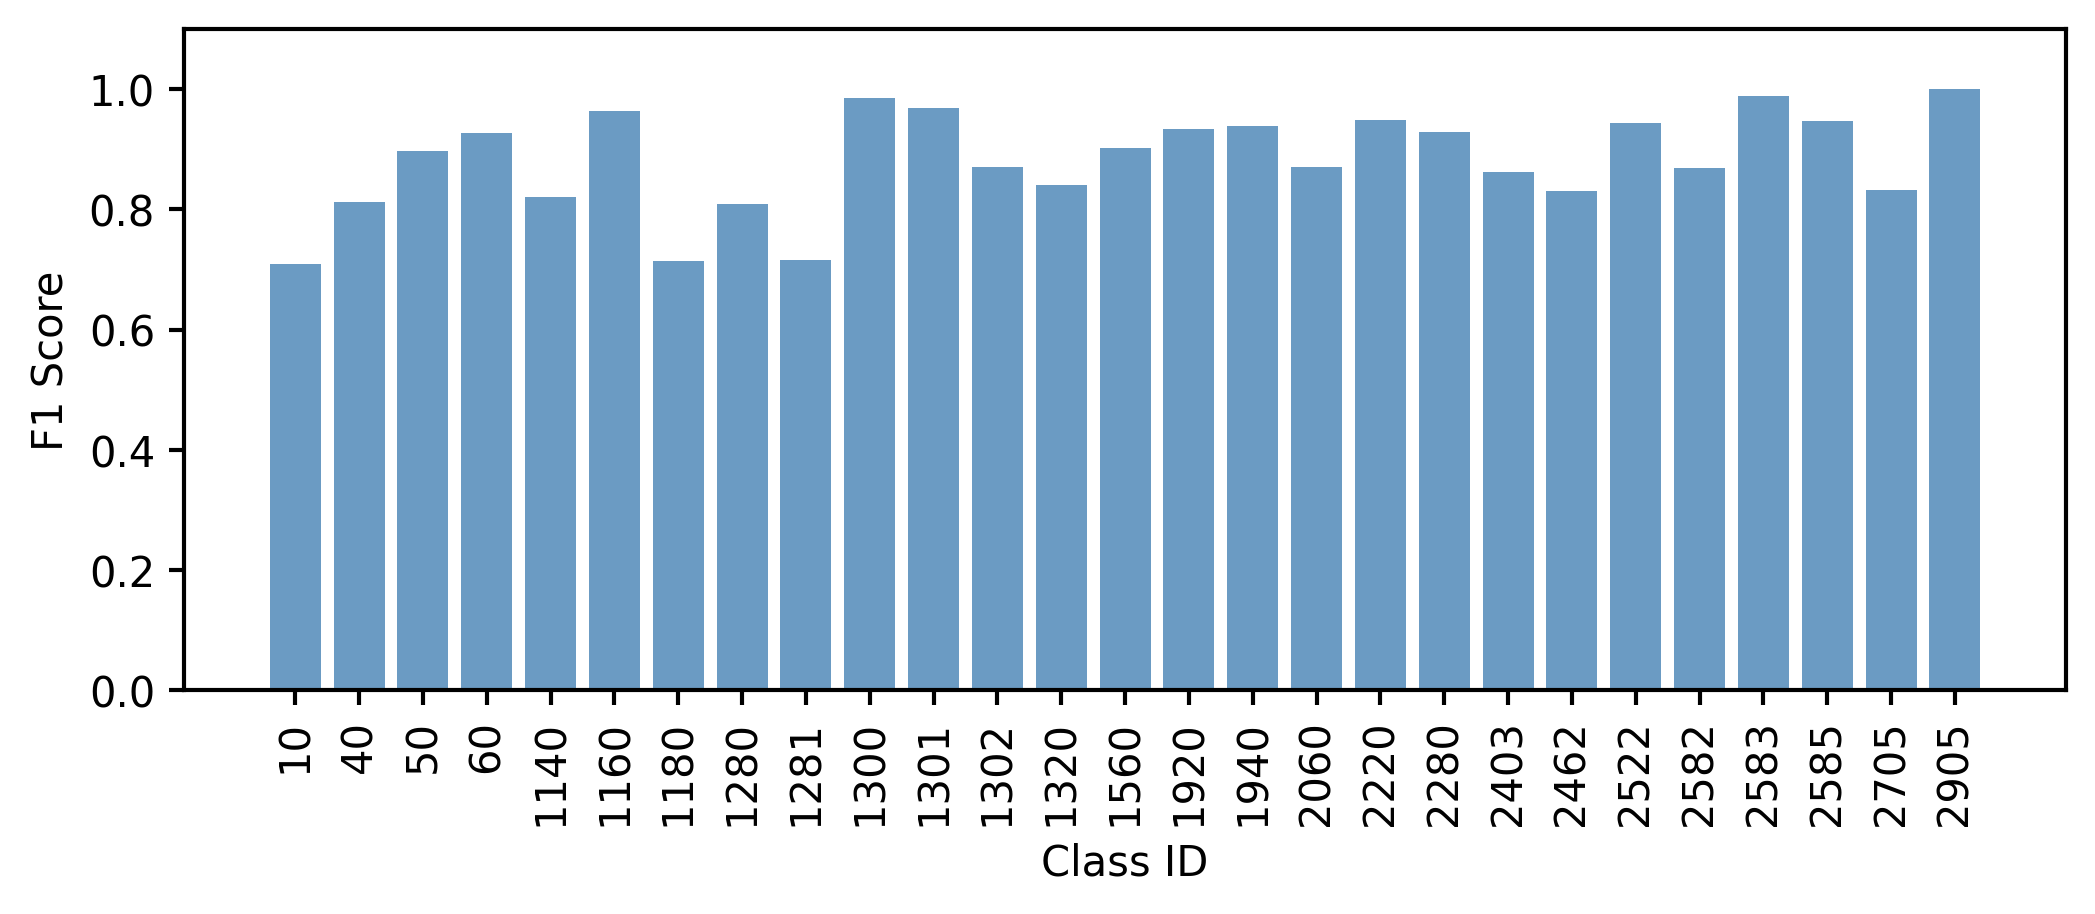


F1 Score Statistics:
  Mean: 0.8827
  Median: 0.8979
  Min: 0.7084 (Class 10)
  Max: 1.0000 (Class 2905)
  Std: 0.0835


In [167]:
# Plot F1 metrics per class as function of class label for all experiments
# or specific experiment
fig, ax = plt.subplots(figsize=(18*cm, 8*cm))

# Get data for the best experiment
best_experiment_id = best_mmBERT["experiment_id"]
best_metrics = metrics[metrics["experiment_id"] == best_experiment_id.iloc[0]].copy()

# Sort by class_id for proper ordering
best_metrics["class_id_int"] = best_metrics["class_id"].astype(int)
best_metrics = best_metrics.sort_values("class_id_int")

# Create bar plot
ax.bar(range(len(best_metrics)), best_metrics["f1"], color='steelblue', alpha=0.8)
ax.set_xticks(range(len(best_metrics)))
ax.set_xticklabels(best_metrics["class_id"], rotation=90)
ax.set_ylim(0, 1.1)
ax.set_xlabel("Class ID")
ax.set_ylabel("F1 Score")
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nF1 Score Statistics:")
print(f"  Mean: {best_metrics['f1'].mean():.4f}")
print(f"  Median: {best_metrics['f1'].median():.4f}")
print(f"  Min: {best_metrics['f1'].min():.4f} (Class {best_metrics.loc[best_metrics['f1'].idxmin(), 'class_id']})")
print(f"  Max: {best_metrics['f1'].max():.4f} (Class {best_metrics.loc[best_metrics['f1'].idxmax(), 'class_id']})")
print(f"  Std: {best_metrics['f1'].std():.4f}")

# save the x and y data for later use in a csv
best_metrics[['class_id', 'f1']].to_csv("best_mmBERT_f1_per_class.csv", index=False)


{'id2label': {'0': '10', '1': '1140', '2': '1160', '3': '1180', '4': '1280', '5': '1281', '6': '1300', '7': '1301', '8': '1302', '9': '1320', '10': '1560', '11': '1920', '12': '1940', '13': '2060', '14': '2220', '15': '2280', '16': '2403', '17': '2462', '18': '2522', '19': '2582', '20': '2583', '21': '2585', '22': '2705', '23': '2905', '24': '40', '25': '50', '26': '60'}, 'label2id': {'10': 0, '1140': 1, '1160': 2, '1180': 3, '1280': 4, '1281': 5, '1300': 6, '1301': 7, '1302': 8, '1320': 9, '1560': 10, '1920': 11, '1940': 12, '2060': 13, '2220': 14, '2280': 15, '2403': 16, '2462': 17, '2522': 18, '2582': 19, '2583': 20, '2585': 21, '2705': 22, '2905': 23, '40': 24, '50': 25, '60': 26}}
Labels sorted: ['10', '1140', '1160', '1180', '1280', '1281', '1300', '1301', '1302', '1320', '1560', '1920', '1940', '2060', '2220', '2280', '2403', '2462', '2522', '2582', '2583', '2585', '2705', '2905', '40', '50', '60']


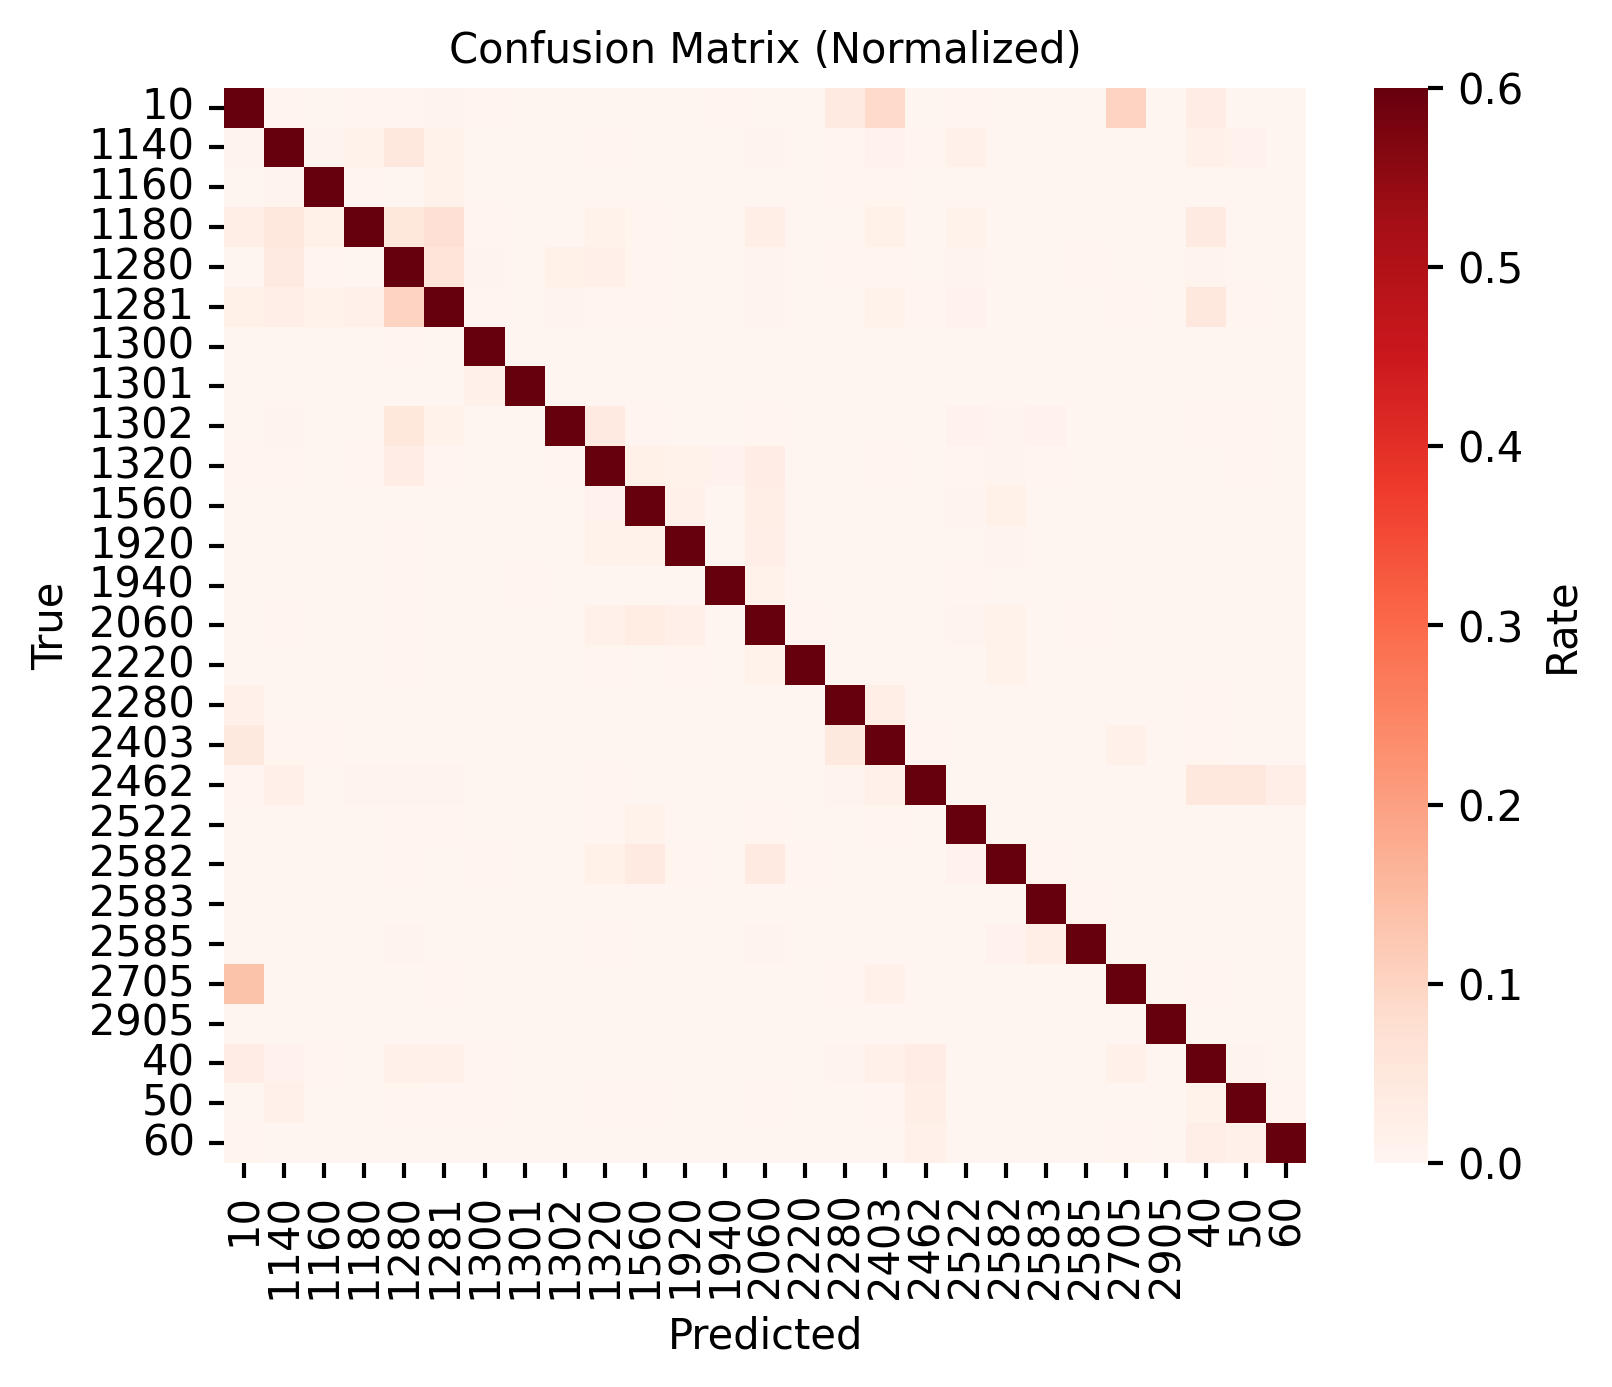

In [168]:
# get confusion matrix for best mmBERT model
experiment_id = best_mmBERT["experiment_id"]
confusion_matrix_path = EXPERIMENTS_DIR / str(experiment_id.iloc[0]) / "confusion_norm.npy"
confusion_matrix = np.load(confusion_matrix_path)

# show structure of confusion matrix
# label by prdtypdecode from label_map.json
with open(EXPERIMENTS_DIR / str(experiment_id.iloc[0]) / "label_map.json", "r") as f:
    label_map = json.load(f)
print(label_map)
labels_sorted = [label_map["id2label"][str(i)] for i in range(len(label_map["id2label"]))]
print("Labels sorted:", labels_sorted)
plt.figure(figsize=(14*cm, 12*cm))
# Get sorted class labels from the best metrics
#
sns.heatmap(confusion_matrix, fmt='.2f', cmap="Reds", 
            xticklabels=labels_sorted, 
            yticklabels=labels_sorted,
            cbar_kws={'label': 'Rate'},
            vmin=0, vmax=0.6)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Normalized)")
plt.tight_layout()
plt.show()

In [169]:
# worst classes
worst_class_ids = best_metrics.nsmallest(5, "f1")["class_id"].tolist()
print("Worst class IDs:", worst_class_ids)

# Create reverse mapping from real class_id to integer index
label2id = label_map["label2id"]

for class_id in worst_class_ids:
    # Convert real class_id to integer index for confusion matrix lookup
    class_id_str = str(class_id)
    integer_idx = label2id[class_id_str]
    
    # get the row for this class in the confusion matrix
    confusion_row = confusion_matrix[integer_idx]
    
    # get top confused classes (sorted by confusion rate)
    top_indices = np.argsort(confusion_row)[::-1]
    
    print(f"\nClass {class_id} (F1={best_metrics[best_metrics['class_id']==class_id]['f1'].values[0]:.3f}):")
    print(f"  True class rate: {confusion_row[integer_idx]:.2%}")
    
    count = 0
    for idx in top_indices:
        if count >= 2:  # Show top 2 confusions
            break
        confused_class = labels_sorted[idx]
        if int(confused_class) != int(class_id):  # Skip the diagonal
            rate = confusion_row[idx]
            print(f"  → Confused with class {confused_class}: {rate:.2%}")
            count += 1


Worst class IDs: [10, 1180, 1281, 1280, 40]

Class 10 (F1=0.708):
  True class rate: 69.98%
  → Confused with class 2705: 9.95%
  → Confused with class 2403: 8.83%

Class 1180 (F1=0.714):
  True class rate: 66.01%
  → Confused with class 1281: 7.19%
  → Confused with class 1280: 5.23%

Class 1281 (F1=0.716):
  True class rate: 71.81%
  → Confused with class 1280: 10.29%
  → Confused with class 40: 4.90%

Class 1280 (F1=0.809):
  True class rate: 79.48%
  → Confused with class 1281: 5.67%
  → Confused with class 1140: 3.92%

Class 40 (F1=0.812):
  True class rate: 82.70%
  → Confused with class 10: 3.22%
  → Confused with class 2462: 2.82%
